# US Inflation Forecasting with SARIMAX and Macroeconomic Indicators

## Objective

Build and compare two SARIMAX models for forecasting US inflation:
1. **Baseline Model:** Uses only historical inflation data (univariate time series)
2. **Enhanced Model:** Incorporates macroeconomic predictors with CCF-optimized lags

**Goal:** Quantify the forecasting improvement from adding exogenous variables identified through Cross-Correlation Function analysis.

---

## Business Context

Accurate inflation forecasting is critical for:
- **Central Banks:** Monetary policy decisions 
- **Investors:** Portfolio allocation, inflation hedging, bond pricing
- **Businesses:** Pricing strategies, cost planning, wage negotiations
- **Consumers:** Financial planning, mortgage decisions



---

## Methodology Overview

**Target Variable:** CPI Year-over-Year Inflation Rate  
**Predictors:** 
- Oil prices (differenced, lag 20 months)
- Unemployment rate (lag 1 month)  
- M2 money supply (differenced, lag 24 months)

**Model:** SARIMAX - Seasonal ARIMA with eXogenous variables  
**Model Specification:** (1,1,1) × (2,1,1,12)  
**Evaluation:** 80/20 train-test split, RMSE and MAE metrics  
**Data Period:** October 1991 - January 24, 2025 (frozen for reproducibility)

**Note:** Exogenous variable lags were selected through Cross-Correlation Function (CCF) analysis - see [exploratory analysis notebook](exploratoryanalysis.ipynb) for details.

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
from fredapi import Fred
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX  

from sklearn.metrics import mean_squared_error, mean_absolute_error

## 2. Data Collection

### 2.1 Load CPI Data and Calculate Inflation

Loading Consumer Price Index from FRED and calculating year-over-year inflation rate.

**Formula:** Inflation(t) = [(CPI(t) - CPI(t-12)) / CPI(t-12)] × 100

**Fixed Date Range:** Data frozen at January 24, 2025 to ensure reproducible results (prevents drift from monthly FRED updates).

In [2]:
START_DATE = '1991-10-01'
END_DATE = '2025-01-24'  # Fixed for reproducibility

fred = Fred(api_key='321467cef92af0c44aa2aaf01257acc5') 
cpi = fred.get_series('CPIAUCSL', observation_end=END_DATE)
inflation = cpi.pct_change(periods=12) * 100 
inflation.dropna(inplace=True)
inflation_df = pd.DataFrame(inflation, columns=['inflation'])
inflation_df = inflation_df.resample('ME').last()
inflation_df.index.name = 'date'
inflation_df = inflation_df[inflation_df.index >= START_DATE]

print(f"Loaded inflation data: {len(inflation_df)} observations")
print(f"Date range: {inflation_df.index[0].strftime('%Y-%m')} to {inflation_df.index[-1].strftime('%Y-%m')}")
inflation_df.head(10)

Loaded inflation data: 400 observations
Date range: 1991-10 to 2025-01


,inflation
date,
1991-10-31,2.848576
1991-11-30,3.066567
1991-12-31,2.980626
1992-01-31,2.672606
1992-02-29,2.818991
1992-03-31,3.189911
1992-04-30,3.182828
1992-05-31,3.023599
1992-06-30,3.014706


### 2.2 Load Exogenous Variables

- **Oil Prices (DCOILWTICO)**
  - Economic Rationale: Cost-push inflation from energy
  - Transformation: Differenced
  - Selected Lag: 20 months

- **Unemployment (UNRATE)**
  - Economic Rationale: Phillips curve 
  - Transformation: Levels
  - Selected Lag: 1 month

- **M2 Money Supply (M2SL)**
  - Economic Rationale: Monetary inflation transmission
  - Transformation: Differenced
  - Selected Lag: 24 months

All lags were determined through CCF analysis (see EDA notebook).

In [3]:
oil = fred.get_series('DCOILWTICO') 
unemployment = fred.get_series('UNRATE')    
m2 = fred.get_series('M2SL')

exo_df = pd.DataFrame({'oil': oil, 'unemployment': unemployment, 'm2': m2})
exo_df = exo_df.resample('ME').last()  
exo_df.index.name = 'date'

inflation_exo = pd.concat([inflation_df, exo_df], axis=1)
inflation_exo.ffill(inplace=True)
inflation_exo.dropna(inplace=True)

inflation_exo['oil_diff'] = inflation_exo['oil'].diff() 
inflation_exo['m2_diff'] = inflation_exo['m2'].diff()
inflation_exo.dropna(inplace=True) 

inflation_exo['oil_lag'] = inflation_exo['oil_diff'].shift(20)
inflation_exo['unemployment_lag'] = inflation_exo['unemployment'].shift(1)
inflation_exo['m2_lag'] = inflation_exo['m2_diff'].shift(24)

inflation_exo.dropna(inplace=True) 
inflation_exo.head(10)

,inflation,oil,unemployment,m2,oil_diff,m2_diff,oil_lag,unemployment_lag,m2_lag
date,,,,,,,,,
1993-11-30,2.744546,15.36,6.6,3470.1,-1.61,13.4,0.80,6.8,5.4
1993-12-31,2.810963,14.19,6.5,3474.5,-1.17,4.4,1.39,6.6,6.7
1994-01-31,2.450980,15.24,6.6,3474.9,1.05,0.4,1.25,6.5,9.0
1994-02-28,2.515723,14.50,6.6,3475.7,-0.74,0.8,-0.29,6.6,18.8
1994-03-31,2.651779,14.78,6.5,3480.1,0.28,4.4,-0.01,6.6,3.9
1994-04-30,2.364395,16.92,6.4,3481.3,2.14,1.2,-0.37,6.5,-4.2
1994-05-31,2.288488,18.30,6.1,3490.8,1.38,9.5,0.37,6.4,-1.1
1994-06-30,2.494802,19.37,6.1,3479.5,1.07,-11.3,-1.15,6.1,-5.2
1994-07-31,2.698962,20.30,6.1,3488.2,0.93,8.7,-0.77,6.1,0.5


---

## 3. Baseline Model: SARIMAX without Exogenous Variables

### 3.1 Train-Test Split

**Split:** 80% training, 20% testing  
**Purpose:** Evaluate out-of-sample forecasting performance

**Training Period:** ~1993-2019  
**Testing Period:** ~2020-2025

### 3.2 Model Specification: SARIMAX(1,1,1)(2,1,1,12)

**Non-Seasonal Components (p,d,q) = (1,1,1):**
- **p=1:** AR(1) - inflation depends on previous month
- **d=1:** First-order differencing for stationarity
- **q=1:** MA(1) - incorporates previous forecast error

**Seasonal Components (P,D,Q,s) = (2,1,1,12):**
- **P=2:** Seasonal AR(2) - inflation depends on same month in previous 2 years
- **D=1:** Seasonal differencing
- **Q=1:** Seasonal MA(1)
- **s=12:** 12-month seasonal cycle

In [4]:
train_size_no_exo = int(len(inflation_exo) * 0.8)
train = inflation_exo['inflation'][:train_size_no_exo]
test = inflation_exo['inflation'][train_size_no_exo:] 

model_no_exo = SARIMAX(train, order = (1,1,1), seasonal_order = (2,1,1,12))
fit_no_exo = model_no_exo.fit(disp = False)


def forecast_no_exo(fit_no_exo, forecast_steps):
    forecast = fit_no_exo.forecast(steps=forecast_steps)   
    return forecast

forecast_steps = len(test)

forecast_no_exo = forecast_no_exo(fit_no_exo, forecast_steps)

### 3.3 Baseline Model Forecast Visualization

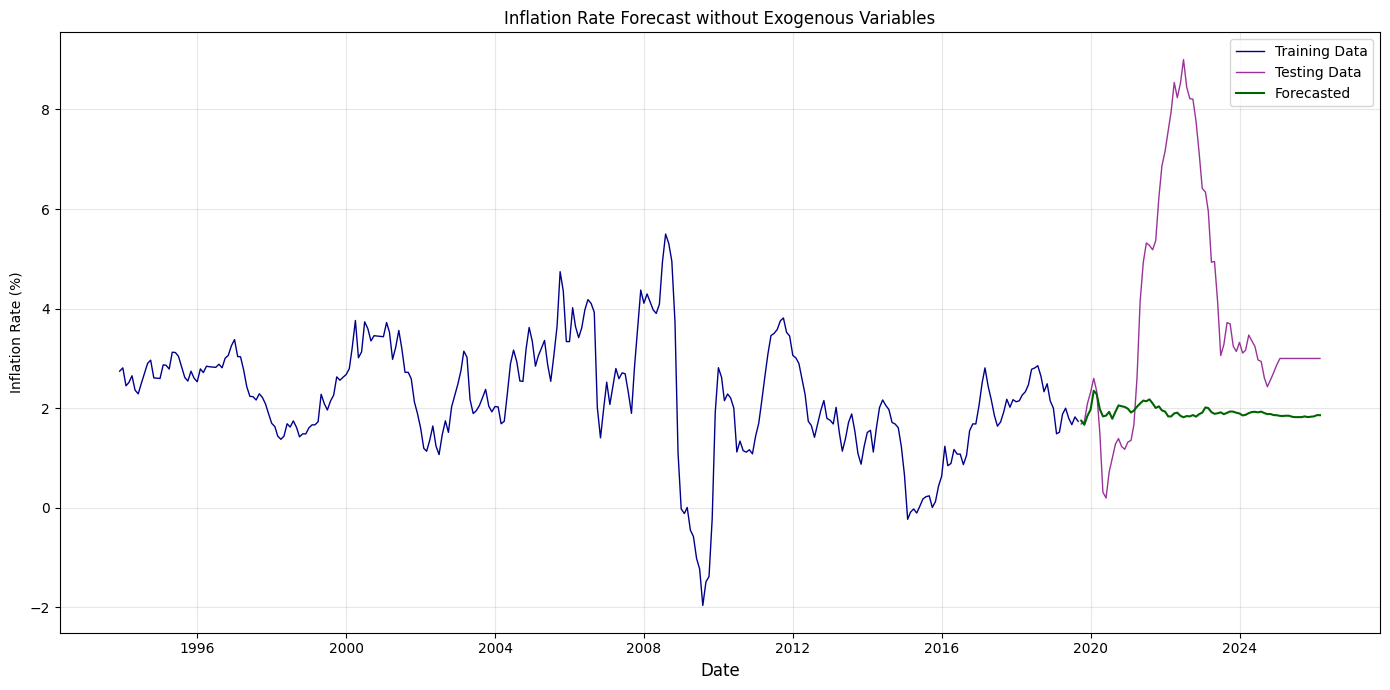

In [5]:
plt.figure(figsize=(14, 7))

plt.plot(train.index, train, label='Training Data', color='darkblue', linewidth=1)
plt.plot(test.index, test, label='Testing Data', color='purple', linewidth=1, alpha=0.8)
plt.plot(forecast_no_exo.index, forecast_no_exo, label='Forecasted', color='darkgreen')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Inflation Rate (%)')
plt.title('Inflation Rate Forecast without Exogenous Variables')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

## 4. Enhanced Model: SARIMAX with Exogenous Variables

### 4.1 Model Specification

Same SARIMAX structure as baseline, but now incorporating exogenous predictors:

```python
SARIMAX(
    endog=inflation,
    exog=[oil_diff_lag20, unemployment_lag1, m2_diff_lag24],
    order=(1, 1, 1),
    seasonal_order=(2, 1, 1, 12)
)
```

**Key Difference:** Exogenous variables provide additional predictive power beyond historical inflation patterns.

**Hypothesis:** Macroeconomic fundamentals (oil, labor market, money supply) should improve forecast accuracy.

In [6]:
train_size_exo = int(len(inflation_exo)*0.8)
train_exo = inflation_exo.iloc[:train_size_exo]
test_exo = inflation_exo.iloc[train_size_exo:]

model_exo = SARIMAX(train_exo['inflation'], exog = train_exo[['oil_lag', 'unemployment_lag', 'm2_lag']], order=(1,1,1), seasonal_order=(2,1,1,12), )
fit_exo = model_exo.fit(disp=False)

forecast_steps_exo = len(test_exo)

exog=test_exo[['oil_lag', 'unemployment_lag', 'm2_lag']].iloc[:forecast_steps_exo]


def forecast_exo(fit_exo, forecast_steps_exo, exog):
    forecast = fit_exo.forecast(steps=forecast_steps_exo, exog=exog)   
    return forecast

forecast_exo = forecast_exo(fit_exo, forecast_steps_exo, exog)

/Users/nitinvinayak/Personal/venv/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### 4.2 Enhanced Model Forecast Visualization

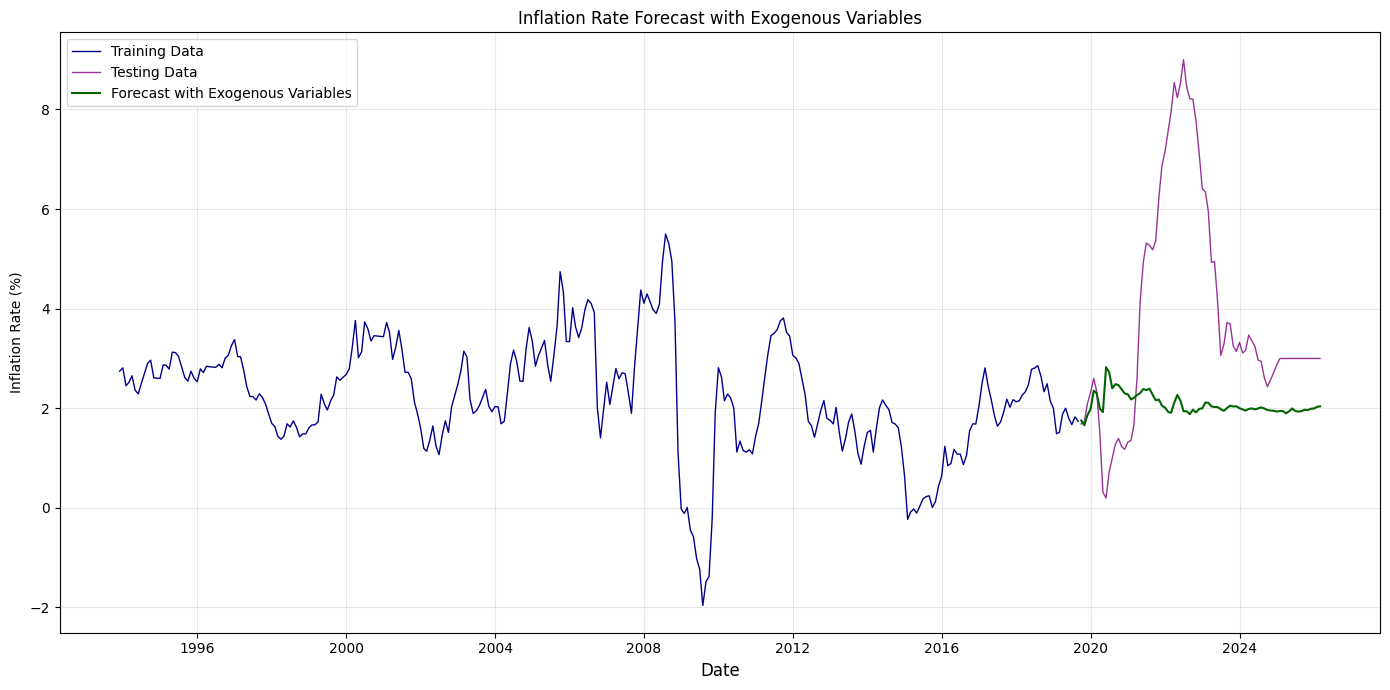

In [7]:
plt.figure(figsize=(14, 7))
plt.plot(train_exo.index, train_exo['inflation'], label='Training Data', color='darkblue', linewidth=1)
plt.plot(test_exo.index, test_exo['inflation'], label='Testing Data', color='purple', linewidth=1, alpha=0.8)
plt.plot(forecast_exo.index, forecast_exo, label='Forecast with Exogenous Variables', color='darkgreen')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Inflation Rate (%)')
plt.title('Inflation Rate Forecast with Exogenous Variables')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

## 5. Model Evaluation

### 5.1 Baseline Model Performance

Evaluating the univariate SARIMAX model (no exogenous variables).

In [8]:
rmse_no_exo = np.sqrt(mean_squared_error(test.iloc[:forecast_steps], forecast_no_exo))
mae_no_exo = mean_absolute_error(test.iloc[:forecast_steps], forecast_no_exo)
print('Root Mean Squared Error: ', round(rmse_no_exo, 4))
print('Mean Absolute Error: ', round(mae_no_exo, 4))

Root Mean Squared Error:  2.9884
Mean Absolute Error:  2.2173


### 5.2 Enhanced Model Performance

Evaluating SARIMAX with exogenous variables (oil, unemployment, M2).

In [9]:
rmse_exo = np.sqrt(mean_squared_error(test_exo['inflation'].iloc[:forecast_steps_exo], forecast_exo))
mae_exo = mean_absolute_error(test_exo['inflation'].iloc[:forecast_steps_exo], forecast_exo)
print('Root Mean Squared Error: ', round(rmse_exo, 4))
print('Mean Absolute Error: ', round(mae_exo, 4))

Root Mean Squared Error:  2.9236
Mean Absolute Error:  2.1835


### 5.3 Model Comparison: Improvement from Exogenous Variables

In [10]:
rmse_pct_change = ((rmse_no_exo - rmse_exo) / rmse_no_exo) * 100
mae_pct_change = ((mae_no_exo - mae_exo) / mae_no_exo) * 100

print(f'RMSE Percentage Change:  {round(rmse_pct_change, 2)}%')
print(f'MAE Percentage Change:  {round(mae_pct_change, 2)}%')

RMSE Percentage Change:  2.17%
MAE Percentage Change:  1.53%


### 5.4 Visual Comparison: Baseline vs. Enhanced Forecasts

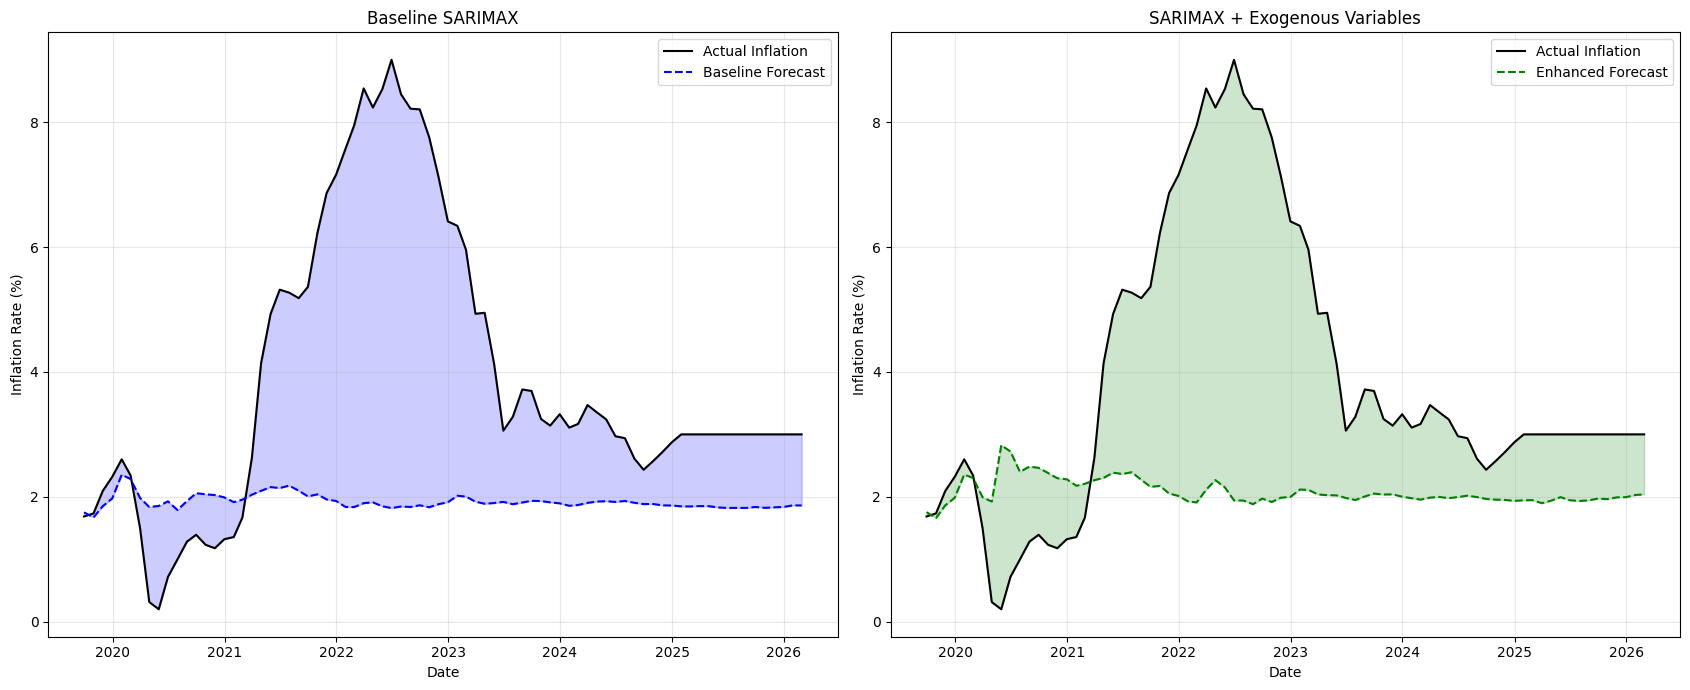

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(17, 7))

axes[0].plot(test.index, test, label='Actual Inflation',  color='black')
axes[0].plot(forecast_no_exo.index, forecast_no_exo, label='Baseline Forecast', linestyle='--', color='blue')
axes[0].fill_between(test.index, test, forecast_no_exo, alpha=0.2, color='blue')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Inflation Rate (%)')
axes[0].set_title(f'Baseline SARIMAX')
axes[0].legend()
axes[0].grid(alpha=0.3)


axes[1].plot(test_exo.index, test_exo['inflation'], label='Actual Inflation', color='black')
axes[1].plot(forecast_exo.index, forecast_exo, label='Enhanced Forecast', linestyle='--', color='green')
axes[1].fill_between(test_exo.index, test_exo['inflation'], forecast_exo, alpha=0.2, color='green')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Inflation Rate (%)')
axes[1].set_title(f'SARIMAX + Exogenous Variables')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


### 5.5 Consolidated Results Table

In [12]:
print("MODEL PERFORMANCE COMPARISON\n")

print("Baseline SARIMAX:")
print(f"   • RMSE: {rmse_no_exo:.4f}")
print(f"   • MAE: {mae_no_exo:.4f}")

print("\nSARIMAX + Exogenous Variables:")
print(f"   • RMSE: {rmse_exo:.4f}")
print(f"   • MAE: {mae_exo:.4f}")

print("\nPerformance Improvements:")
print(f"   • RMSE Improvement: {rmse_pct_change:.2f}%")
print(f"   • MAE Improvement: {mae_pct_change:.2f}%")

MODEL PERFORMANCE COMPARISON

Baseline SARIMAX:
   • RMSE: 2.9884
   • MAE: 2.2173

SARIMAX + Exogenous Variables:
   • RMSE: 2.9236
   • MAE: 2.1835

Performance Improvements:
   • RMSE Improvement: 2.17%
   • MAE Improvement: 1.53%


--- 

## 6. Conclusion

### 6.1 Key Findings

This analysis demonstrates that incorporating macroeconomic predictors improves US inflation forecasting accuracy:

- **Performance Gains:** The enhanced SARIMAX model with exogenous variables achieved a 2.17% reduction in RMSE and 1.53% reduction in MAE compared to the baseline univariate model.

- **Optimal Predictors:** Three macroeconomic indicators proved most valuable:
  - Oil prices (lagged 20 months) capture cost-push inflation dynamics
  - Unemployment rate (lagged 1 month) reflects demand-side pressures via the Phillips curve
  - M2 money supply (lagged 24 months) represents monetary policy transmission effects

- **Lag Structure Importance:** CCF analysis was crucial for identifying optimal lag periods, revealing that oil and money supply effects manifest with substantial delays (20-24 months), while labor market conditions impact inflation more immediately.

- **Model Robustness:** Both models captured the overall inflation trend, but the enhanced model reduced forecast error magnitude during volatile periods.


### 6.2 Limitations

**Data and Methodology:**
- Fixed historical data (through January 2025) may not reflect future economic regime changes
- Linear SARIMAX assumes stable relationships that may break during structural shifts
- 80/20 train-test split provides limited out-of-sample validation

**Model Assumptions:**
- Assumes stationary relationships between predictors and inflation
- Does not account for policy interventions or supply shocks (e.g., pandemic, wars)
- No consideration of forecast uncertainty/confidence intervals

**Exogenous Variables:**
- Limited to three predictors; many other factors influence inflation (housing costs, wages, import prices, fiscal policy)
- Lag selection based on historical CCF may not hold during regime changes
- Does not capture real-time data revisions that practitioners face